# Image classification with TensorFlow Lite Model Maker

## Part 1: TensorFlow Evaluation

### Step 0: Prerequisites

To run this example, we first need to install several required packages, including Model Maker package that in GitHub [repo](https://github.com/tensorflow/examples/tree/master/tensorflow_examples/lite/model_maker).

In [1]:
!pip install -q tensorflow==2.7.0
!pip install -q flatbuffers==1.12

In [2]:
import tensorflow
print(tensorflow.__version__)

2.7.0


In [3]:
!pip install -q tflite-model-maker

Import the required packages.

In [4]:
import os
# import cv2
import numpy as np

import tensorflow as tf
from tensorflow.python.client import device_lib
assert tf.__version__.startswith('2')

from tflite_model_maker import model_spec
from tflite_model_maker import image_classifier
from tflite_model_maker.config import ExportFormat
from tflite_model_maker.config import QuantizationConfig
from tflite_model_maker.image_classifier import DataLoader

import matplotlib.pyplot as plt

from google.colab import drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

import logging
logging.getLogger('googleapiclient.discovery_cache').setLevel(logging.ERROR)

import time
from datetime import datetime

import multiprocessing
import csv   

In [5]:
# Constants
training_dataset_path = '/gdrive/MyDrive/Colab Notebooks/data/gaf_output/content/gaf_output/training/'
test_dataset_path = '/gdrive/MyDrive/Colab Notebooks/data/gaf_output/content/gaf_output/test/'
folder_name = 'content/gaf/gaf_output/'
test_dataset_fileid = '13vOy94hClYWFK98kzYUn8IHgC6jSxFV0'
test_dataset_filename = 'gaf_dataset_test.csv'
tflite_model_filename = 'model.tflite'
EPOCHS = 35

Step 1.   Load input data specific to an on-device ML app. Split it into training data and testing data.

In [6]:
# Mount Google Drive
drive.mount('/gdrive', force_remount=True)
%cd /gdrive/MyDrive/Colab\ Notebooks/data/gaf_output/content/gaf_output

Mounted at /gdrive
/gdrive/MyDrive/Colab Notebooks/data/gaf_output/content/gaf_output


In [7]:
# Create dataset from folder
data = DataLoader.from_folder(training_dataset_path)

INFO:tensorflow:Load image with size: 1467, num_label: 2, labels: abnormal, normal.


Split it to training data (80%), validation data (10%, optional) and testing data (10%).

In [8]:
# Split dataset into training, validation, and testing subsets
train_data, rest_data = data.split(0.8)
validation_data, test_data = rest_data.split(0.5)
print('Data sizes:', data.size, train_data.size, rest_data.size, validation_data.size, test_data.size)

Data sizes: 1467 1173 294 147 147


Show 25 image examples with labels.

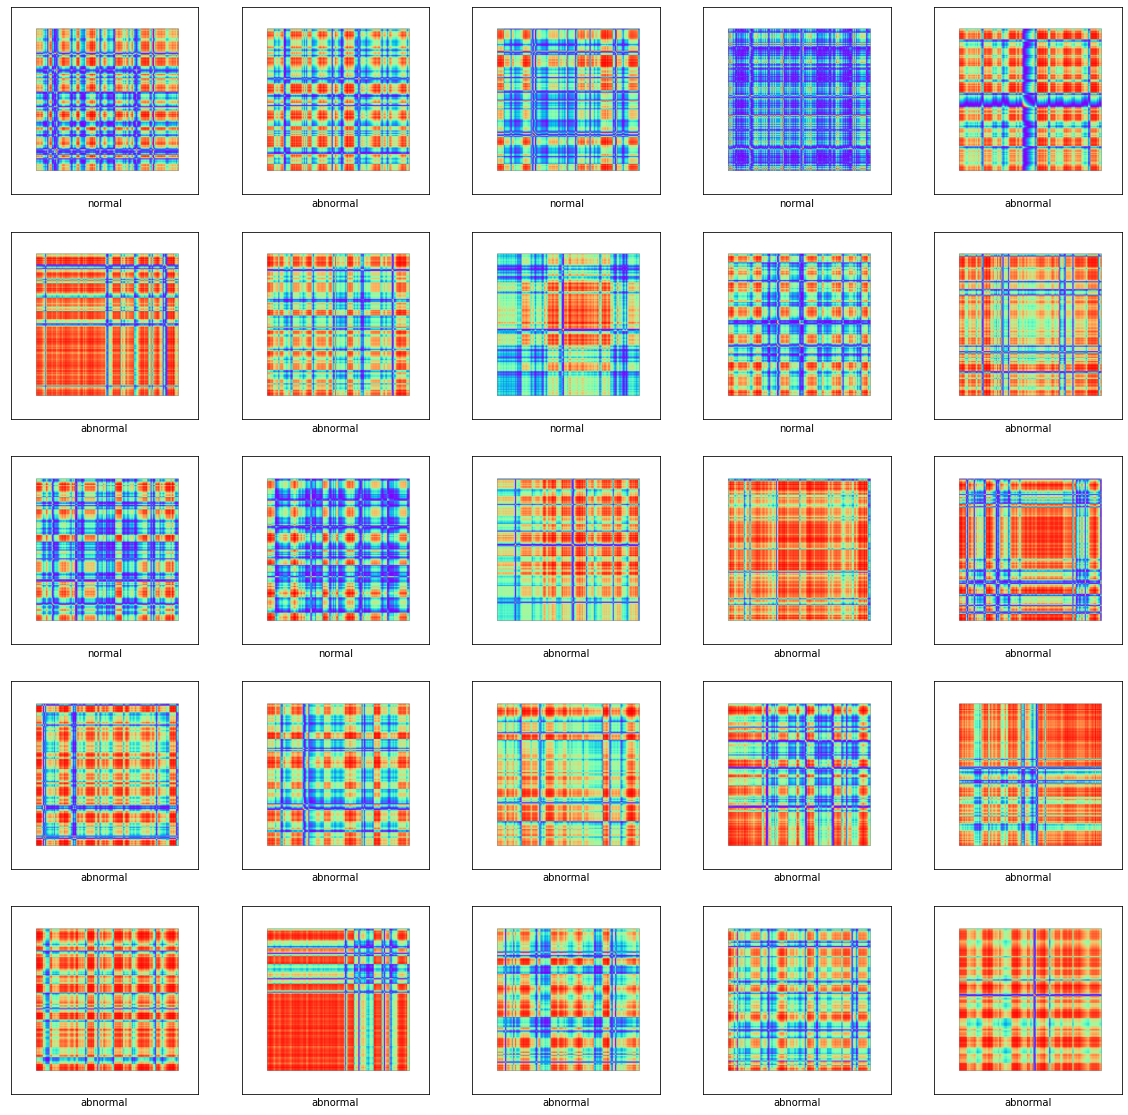

In [9]:
plt.figure(figsize=(20,20))
for i, (image, label) in enumerate(data.gen_dataset().unbatch().take(25)):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(image.numpy(), cmap=plt.cm.gray)
  plt.xlabel(data.index_to_label[label.numpy()])
plt.show()

### Step 1: Customize the TensorFlow Model

Create a custom image classifier model based on the loaded data. The default model is EfficientNet-Lite0.


In [10]:
training_time_start = time.clock()
model = image_classifier.create(train_data, validation_data=validation_data, epochs=EPOCHS)
training_time_elapsed = (time.clock() - training_time_start)
print('training_time_elapsed:', training_time_elapsed)

INFO:tensorflow:Retraining the models...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """Entry point for launching an IPython kernel.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hub_keras_layer_v1v2 (HubKe  (None, 1280)             3413024   
 rasLayerV1V2)                                                   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 3,415,586
Trainable params: 2,562
Non-trainable params: 3,413,024
_________________________________________________________________
None


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/35
36/36 [==============================] - 43s 907ms/step - loss: 0.5353 - accuracy: 0.8056 - val_loss: 0.4270 - val_accuracy: 0.8435
Epoch 2/35
36/36 [==============================] - 33s 922ms/step - loss: 0.4494 - accuracy: 0.8455 - val_loss: 0.3891 - val_accuracy: 0.8707
Epoch 3/35
36/36 [==============================] - 35s 967ms/step - loss: 0.4242 - accuracy: 0.8733 - val_loss: 0.3772 - val_accuracy: 0.8980
Epoch 4/35
36/36 [==============================] - 33s 923ms/step - loss: 0.4138 - accuracy: 0.8698 - val_loss: 0.3671 - val_accuracy: 0.9116
Epoch 5/35
36/36 [==============================] - 33s 928ms/step - loss: 0.4005 - accuracy: 0.8793 - val_loss: 0.3605 - val_accuracy: 0.8707
Epoch 6/35
36/36 [==============================] - 33s 929ms/step - loss: 0.3929 - accuracy: 0.8837 - val_loss: 0.3516 - val_accuracy: 0.8844
Epoch 7/35
36/36 [==============================] - 33s 921ms/step - loss: 0.3871 - accuracy: 0.8837 - val_loss: 0.3513 - val_accuracy: 0.8844

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  This is separate from the ipykernel package so we can avoid doing imports until


Have a look at the detailed model structure.

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hub_keras_layer_v1v2 (HubKe  (None, 1280)             3413024   
 rasLayerV1V2)                                                   
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 3,415,586
Trainable params: 2,562
Non-trainable params: 3,413,024
_________________________________________________________________


### Step 2: Evaluate the Customized Model

Evaluate the result of the model, get the loss and accuracy of the model.

In [12]:
eval_time_start = time.clock()
loss, accuracy = model.evaluate(test_data)
eval_time_elapsed = (time.clock() - eval_time_start)
print('eval_time_elapsed:', eval_time_elapsed)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """Entry point for launching an IPython kernel.


5/5 [==============================] - 12s 542ms/step - loss: 0.3550 - accuracy: 0.9116
eval_time_elapsed: 19.307256999999936


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  This is separate from the ipykernel package so we can avoid doing imports until


We could plot the predicted results in 100 test images. Predicted labels with red color are the wrong predicted results while others are correct.

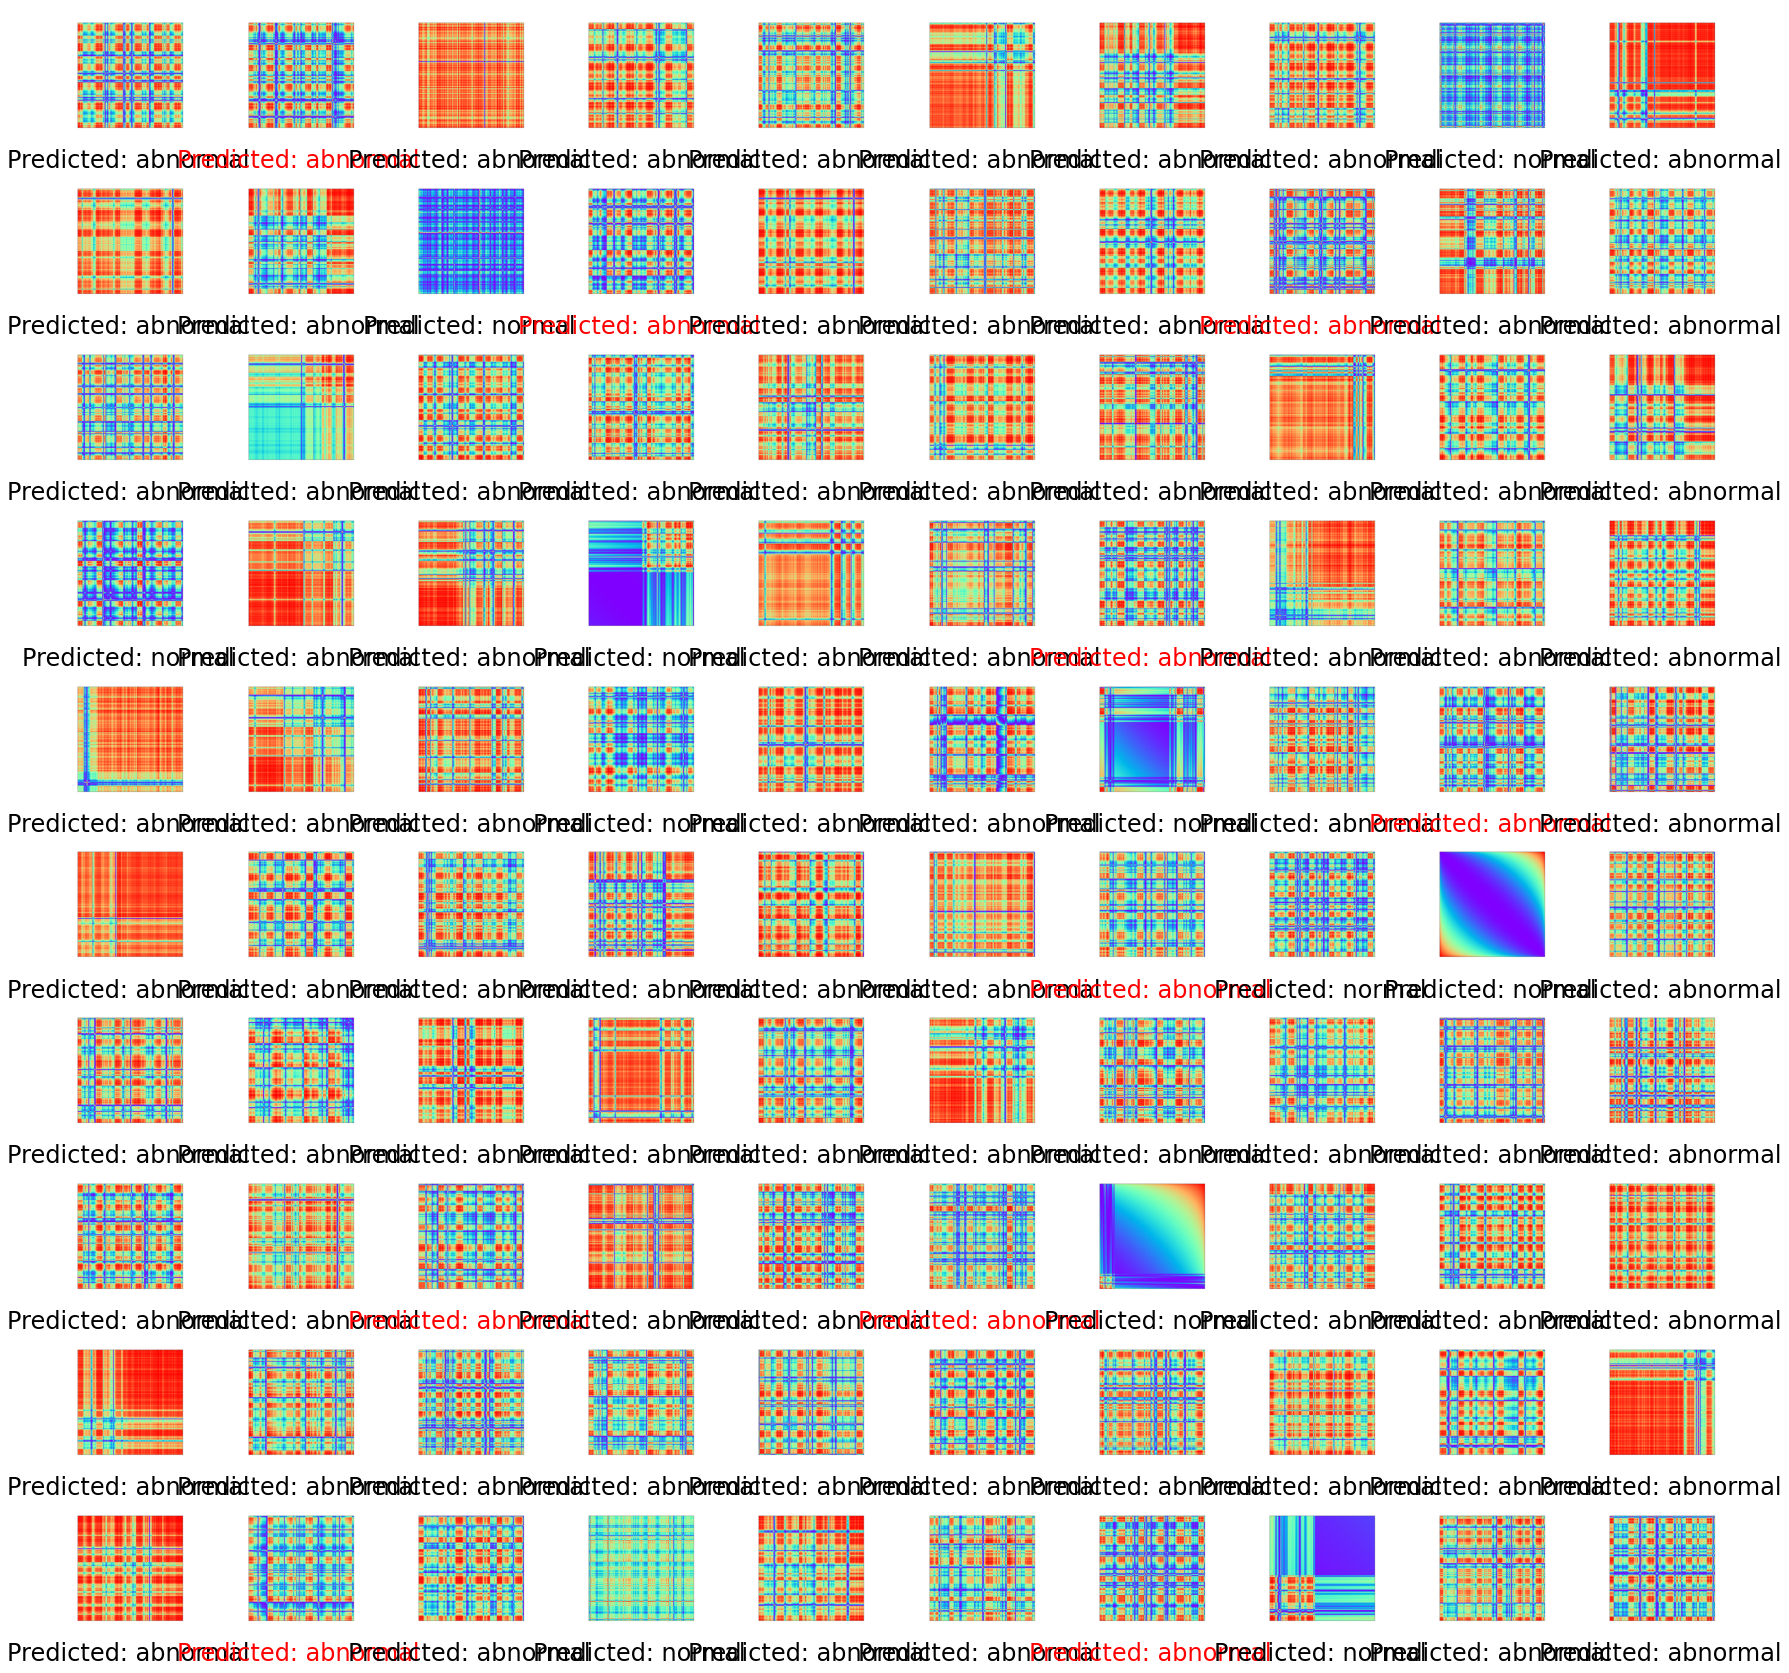

In [26]:
# A helper function that returns 'red'/'black' depending on if its two input
# parameter matches or not.
def get_label_color(val1, val2):
  if val1 == val2:
    return 'black'
  else:
    return 'red'

# Then plot 100 test images and their predicted labels.
# If a prediction result is different from the label provided label in "test"
# dataset, we will highlight it in red color.
plt.figure(figsize=(30, 30))
predicts = model.predict_top_k(test_data)
for i, (image, label) in enumerate(test_data.gen_dataset().unbatch().take(100)):
  ax = plt.subplot(10, 10, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(image.numpy(), cmap=plt.cm.gray)

  predict_label = predicts[i][0][0]
  color = get_label_color(predict_label,
                          test_data.index_to_label[label.numpy()])
  ax.xaxis.label.set_color(color)
  plt.xlabel('Predicted: %s' % predict_label)
plt.show()

If the accuracy doesn't meet the app requirement, one could refer to [Advanced Usage](#scrollTo=zNDBP2qA54aK) to explore alternatives such as changing to a larger model, adjusting re-training parameters etc.

### Step 3: Export to TensorFlow Lite Model

Convert the trained model to TensorFlow Lite model format with [metadata](https://www.tensorflow.org/lite/convert/metadata) so that you can later use in an on-device ML application. The label file and the vocab file are embedded in metadata. The default TFLite filename is `model.tflite`.

In many on-device ML application, the model size is an important factor. Therefore, it is recommended that you apply quantize the model to make it smaller and potentially run faster.
The default post-training quantization technique is full integer quantization for the image classification task.

In [14]:
model_export_time_start = time.clock()
model.export(export_dir='.', tflite_filename='epochs-' + str(EPOCHS) + '-' + tflite_model_filename)
model_export_time_elapsed = (time.clock() - model_export_time_start)
print('model_export_time_elapsed:', model_export_time_elapsed)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """Entry point for launching an IPython kernel.


INFO:tensorflow:Assets written to: /tmp/tmpq0847oxk/assets


INFO:tensorflow:Assets written to: /tmp/tmpq0847oxk/assets


INFO:tensorflow:Label file is inside the TFLite model with metadata.


INFO:tensorflow:Label file is inside the TFLite model with metadata.


INFO:tensorflow:Saving labels in /tmp/tmphbavzx7u/labels.txt


INFO:tensorflow:Saving labels in /tmp/tmphbavzx7u/labels.txt


INFO:tensorflow:TensorFlow Lite model exported successfully: ./epochs-35-model.tflite


INFO:tensorflow:TensorFlow Lite model exported successfully: ./epochs-35-model.tflite


model_export_time_elapsed: 95.47417499999983


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  This is separate from the ipykernel package so we can avoid doing imports until


In [15]:
model.export(export_dir='.', export_format=ExportFormat.LABEL)

INFO:tensorflow:Saving labels in ./labels.txt


INFO:tensorflow:Saving labels in ./labels.txt


You can also evaluate the tflite model with the `evaluate_tflite` method.

In [16]:
tflite_eval_time_start = time.process_time()
tflite_accuracy = model.evaluate_tflite('epochs-' + str(EPOCHS) + '-' + tflite_model_filename, test_data)
print('TFLite accuracy:', tflite_accuracy)
tflite_eval_time_elapsed = time.process_time()
tflite_eval_time_elapsed = (tflite_eval_time_elapsed - tflite_eval_time_start)
print('tflite_eval_time_elapsed:', tflite_eval_time_elapsed)

TFLite accuracy: {'accuracy': 0.8843537414965986}
tflite_eval_time_elapsed: 194.41609499100014


### Advanced Usage Tips

The `create` function is the critical part of this library. It uses transfer learning with a pretrained model similar to the [tutorial](https://www.tensorflow.org/tutorials/images/transfer_learning).

The `create` function contains the following steps:

1.   Split the data into training, validation, testing data according to parameter `validation_ratio` and `test_ratio`. The default value of `validation_ratio` and `test_ratio` are `0.1` and `0.1`.
2.   Download a [Image Feature Vector](https://www.tensorflow.org/hub/common_signatures/images#image_feature_vector) as the base model from TensorFlow Hub. The default pre-trained model is  EfficientNet-Lite0.
3.   Add a classifier head with a Dropout Layer with `dropout_rate` between head layer and pre-trained model. The default `dropout_rate` is the default `dropout_rate` value from [make_image_classifier_lib](https://github.com/tensorflow/hub/blob/master/tensorflow_hub/tools/make_image_classifier/make_image_classifier_lib.py#L55) by TensorFlow Hub.
4.   Preprocess the raw input data. Currently, preprocessing steps including normalizing the value of each image pixel to model input scale and resizing it to model input size.   EfficientNet-Lite0 have the input scale `[0, 1]` and the input image size `[224, 224, 3]`.
5.   Feed the data into the classifier model. By default, the training parameters such as training epochs, batch size, learning rate, momentum are the default values from [make_image_classifier_lib](https://github.com/tensorflow/hub/blob/master/tensorflow_hub/tools/make_image_classifier/make_image_classifier_lib.py#L55) by TensorFlow Hub. Only the classifier head is trained.


In this section, we describe several advanced topics, including switching to a different image classification model, changing the training hyperparameters etc.


## Part 2: TFLite Evaluation

In [17]:
files_list = []
labels = ['abnormal', 'normal'] # in correct order

In [18]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

import logging
import pandas as pd
import tensorflow as tf
import numpy as np
import cv2

# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
logging.getLogger('googleapiclient.discovery_cache').setLevel(logging.ERROR)

In [19]:
# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

_dataset = drive.CreateFile({'id': test_dataset_fileid})
edge_dataset_file = _dataset.GetContentFile(test_dataset_filename)

In [20]:
edge_dataset = pd.read_csv(test_dataset_filename, header=0)
files_list = edge_dataset['image_name'].values
# print(files_list)
print(edge_dataset.head())
# sample = edge_dataset.loc[edge_dataset['image_name'] == '8475769_3dea463364_m.jpg'].label_no[0]
# sample_alt = edge_dataset.loc[edge_dataset['image_name'] == '8475769_3dea463364_m.jpg']['label_no'][0]
# print(sample_alt)

       image_name     label  label_no
0  2012_11_09.png    normal         0
1  2012_11_10.png    normal         0
2  2012_11_11.png  abnormal         1
3  2012_11_12.png  abnormal         1
4  2012_11_13.png  abnormal         1


In [21]:
tflite_model_eval2_time_start = time.clock()
interpreter = tf.lite.Interpreter(model_path='epochs-' + str(EPOCHS) + '-' + tflite_model_filename)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print('Display inputs and outputs:')
print(input_details)
print(output_details)

print('files_list:', len(files_list))

height = input_details[0]['shape'][1]
width = input_details[0]['shape'][2]
print('width:', width, 'height', height)
predictions = []

for file in files_list:
  image_path = test_dataset_path + file 
  print('file:', image_path)
  image = cv2.imread(image_path)
  image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  imH, imW, _ = image.shape 
  image_resized = cv2.resize(image_rgb, (width, height))
  input_data = np.expand_dims(image_resized, axis=0)

  # Perform the actual detection by running the model with the image as input
  interpreter.set_tensor(input_details[0]['index'],input_data)
  interpreter.invoke()

  prediction_tensor = interpreter.get_tensor(output_details[0]['index']) 
  prediction = not bool(np.argmax(prediction_tensor))
  prediction_label = labels[np.argmax(prediction_tensor)]
  predictions.append(prediction)
  print('TFLite tensor:', prediction_tensor, '- prediction label:', prediction_label, '- prediction:', prediction)
tflite_model_eval2_time_elapsed = time.clock() - tflite_model_eval2_time_start
print('tflite_model_eval_time_elapsed:', tflite_model_eval2_time_elapsed)

Display inputs and outputs:
[{'name': 'input_1', 'index': 0, 'shape': array([  1, 224, 224,   3], dtype=int32), 'shape_signature': array([ -1, 224, 224,   3], dtype=int32), 'dtype': <class 'numpy.uint8'>, 'quantization': (0.003921568859368563, 0), 'quantization_parameters': {'scales': array([0.00392157], dtype=float32), 'zero_points': array([0], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
[{'name': 'Identity', 'index': 168, 'shape': array([1, 2], dtype=int32), 'shape_signature': array([-1,  2], dtype=int32), 'dtype': <class 'numpy.uint8'>, 'quantization': (0.00390625, 0), 'quantization_parameters': {'scales': array([0.00390625], dtype=float32), 'zero_points': array([0], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
files_list: 163
width: 224 height 224
file: /gdrive/MyDrive/Colab Notebooks/data/gaf_output/content/gaf_output/test/2012_11_09.png


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """Entry point for launching an IPython kernel.


TFLite tensor: [[ 86 170]] - prediction label: normal - prediction: False
file: /gdrive/MyDrive/Colab Notebooks/data/gaf_output/content/gaf_output/test/2012_11_10.png
TFLite tensor: [[ 73 183]] - prediction label: normal - prediction: False
file: /gdrive/MyDrive/Colab Notebooks/data/gaf_output/content/gaf_output/test/2012_11_11.png
TFLite tensor: [[ 38 218]] - prediction label: normal - prediction: False
file: /gdrive/MyDrive/Colab Notebooks/data/gaf_output/content/gaf_output/test/2012_11_12.png
TFLite tensor: [[214  42]] - prediction label: abnormal - prediction: True
file: /gdrive/MyDrive/Colab Notebooks/data/gaf_output/content/gaf_output/test/2012_11_13.png
TFLite tensor: [[233  23]] - prediction label: abnormal - prediction: True
file: /gdrive/MyDrive/Colab Notebooks/data/gaf_output/content/gaf_output/test/2012_11_14.png
TFLite tensor: [[109 147]] - prediction label: normal - prediction: False
file: /gdrive/MyDrive/Colab Notebooks/data/gaf_output/content/gaf_output/test/2012_11_15.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


In [22]:
def metrics(actual: np.array, predicted: np.array) -> np.array:
    # Confusion matrix elements
    TP = np.count_nonzero(predicted * actual)
    TN = np.count_nonzero((predicted - 1) * (actual - 1))
    FP = np.count_nonzero(predicted * (actual - 1))
    FN = np.count_nonzero((predicted - 1) * actual)

    # Classification evaluation metrics
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1 = 2 * precision * recall / (precision + recall)
    accuracy = (TP + TN) / (TP + TN + FP + FN)

    return np.array([precision, recall, f1, accuracy])

_predictions = np.array(predictions)
_actual = edge_dataset['label_no'].values.astype('bool')
tflite_precision, tflite_recall, tflite_f1, tflite_accuracy2 = metrics(_actual, _predictions)
print('TFLite precision:', tflite_precision, 'recall:', tflite_recall, 'f1:', tflite_f1, 'accuracy:', tflite_accuracy2)


TFLite precision: 0.9052631578947369 recall: 0.9347826086956522 f1: 0.9197860962566845 accuracy: 0.9079754601226994


[[62  9]
 [ 6 86]]


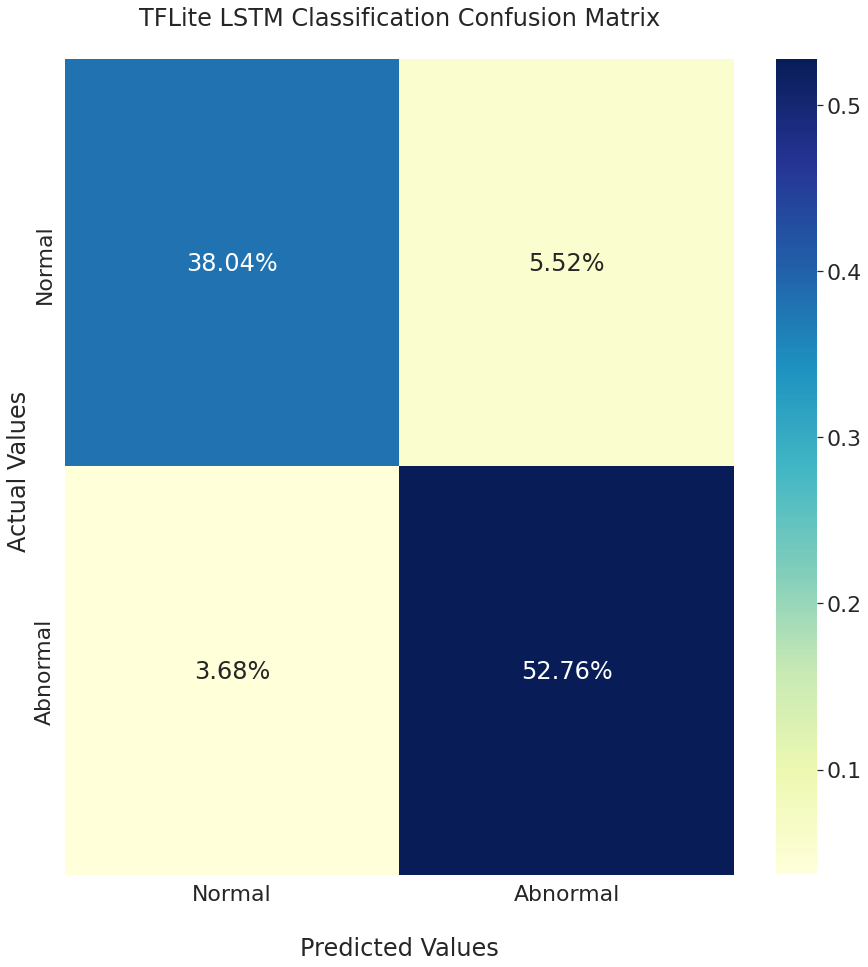

In [23]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
sns.set(rc={'figure.figsize':(15,15)}, font_scale=2)

#Generate the confusion matrix
cf_matrix = confusion_matrix(_actual, _predictions)
print(cf_matrix)

ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, cmap='YlGnBu', fmt='.2%')

ax.set_title('TFLite LSTM Classification Confusion Matrix\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['Normal','Abnormal'])
ax.yaxis.set_ticklabels(['Normal','Abnormal'])

plt.show()

In [24]:
timestamp = str(datetime.now())
stats = f'''Run stats (in sec) - {timestamp}
--------------------------TF---------------------------
training_time_elapsed: {training_time_elapsed}
eval_time_elapsed: {eval_time_elapsed} - accuracy: {accuracy}
model_export_time_elapsed: {model_export_time_elapsed}
---------------------------TFLite-----------------------
tflite_eval_time_elapsed (using model maker): {tflite_eval_time_elapsed} - accuracy: {tflite_accuracy}
tflite_model_eval2_time_elapsed (using interpreter): {tflite_model_eval2_time_elapsed} - accuracy: {tflite_accuracy2}
-------------------------------------------------------
No. of CPU cores: {multiprocessing.cpu_count()}
Hardware: {device_lib.list_local_devices()}
'''
print(stats)

# Save stats as a text file
with open('stats - ' + timestamp + '.csv', "a") as text_file:
    text_file.write(stats)

Run stats (in sec) - 2021-12-21 04:02:08.706315
--------------------------TF---------------------------
training_time_elapsed: 2084.617158
eval_time_elapsed: 19.307256999999936 - accuracy: 0.9115646481513977
model_export_time_elapsed: 95.47417499999983
---------------------------TFLite-----------------------
tflite_eval_time_elapsed (using model maker): 194.41609499100014 - accuracy: {'accuracy': 0.8843537414965986}
tflite_model_eval2_time_elapsed (using interpreter): 196.85281200000009 - accuracy: 0.9079754601226994
-------------------------------------------------------
No. of CPU cores: 2
Hardware: [name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4097899440601060118
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11321147392
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11659605285704224680
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
xla_global_id: 41

In [25]:
# csv file header: ['timestamp', 'training_time_elapsed', 'eval_time_elapsed', 'model_export_time_elapsed', 'tflite_eval_time_elapsed', 'tflite_model_eval2_time_elapsed', 'accuracy', 'tflite_accuracy', 'tflite_accuracy2', 'epochs'])
stats_list = [timestamp, training_time_elapsed, eval_time_elapsed, model_export_time_elapsed, tflite_eval_time_elapsed, tflite_model_eval2_time_elapsed, accuracy, tflite_accuracy, tflite_accuracy2, EPOCHS]
with open('../stats' + '.csv', "a") as csv_output_file:
    writer = csv.writer(csv_output_file)
    writer.writerow(stats_list)

# tflite csv file header: ['timestamp', 'tflite_eval_time_elapsed', 'tflite_model_eval2_time_elapsed', 'tflite_precision', 'tflite_recall', 'tflite_f1', 'tflite_accuracy'])
tflite_stats_list = [timestamp, tflite_eval_time_elapsed, tflite_model_eval2_time_elapsed, tflite_precision, tflite_recall, tflite_f1, tflite_accuracy2]
with open('../tflite_stats' + '.csv', "a") as csv_output_file:
    writer = csv.writer(csv_output_file)
    writer.writerow(tflite_stats_list)